In [1]:
import os
import random 

import pandas as pd 
import numpy as np 
from scipy.stats import kurtosis, skew 
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns
# Importing librarys to use on interactive graphs
import plotly.offline as plty
from plotly import tools
import plotly.express as px
import time
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import json # to convert json in df
from pandas import json_normalize # to normalize the json file
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip -q "./gdrive/MyDrive/train-255.zip"

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
df_train=pd.read_csv('./train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
df_train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [7]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
def json_read(df):
    df = pd.read_csv(df, converters={column: json.loads for column in columns},dtype={'fullVisitorId': 'str'}) 
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df 

In [8]:
df = json_read("./train.csv")

In [9]:
df.to_csv('255-df-format.csv')

In [10]:
df_file = pd.read_csv('255-df-format.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,55) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
df_file.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1.0,1.0,1.0,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not av

In [12]:
df_file.shape

(903653, 56)

In [13]:
df # 900000 rows with 55 columns

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [14]:
df.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector              

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [16]:
df['totals.pageviews'].mode()

0    1
dtype: object

In [17]:
columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
print("No. of variables with unique value: {}".format(len(columns_to_remove)))

No. of variables with unique value: 24


In [18]:
columns_to_remove

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

In [19]:
for col in columns_to_remove:
    if set(['not available in demo dataset']) ==  set(df[col].unique()): continue
    print(col, df[col].dtypes, df[col].unique())

socialEngagementType object ['Not Socially Engaged']
totals.visits object ['1']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
trafficSource.isTrueDirect object [nan True]
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']


In [20]:
# Creating another copy for filling missing values

In [21]:
df_1 = df.copy()

In [22]:
df_1.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [23]:
df_1['totals.pageviews'].fillna(1, inplace=True) # mode of page views is 1
df_1['totals.newVisits'].fillna(0, inplace=True)
df_1['totals.bounces'].fillna(0, inplace=True) 
df_1["totals.transactionRevenue"].fillna(0.0, inplace=True)

In [24]:
#Changing objects to int
df_1['totals.pageviews'] = df_1['totals.pageviews'].astype(int)
df_1['totals.newVisits'] = df_1['totals.newVisits'].astype(int)
df_1['totals.bounces'] = df_1['totals.bounces'].astype(int)
df_1["totals.transactionRevenue"] = df_1["totals.transactionRevenue"].astype(float)

In [25]:
df_1['trafficSource.isTrueDirect'].fillna(False, inplace=True) 
df_1['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True


In [26]:
# df_1[df_1['geoNetwork.city'] == "(not available in demo dataset)"]['geoNetwork.city'] = np.nan
# df_1['geoNetwork.city'].fillna("NaN", inplace=True)

In [27]:
df_1.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector              

In [28]:
columns = [col for col in df_1.columns if df_1[col].nunique() > 1]
df_1 = df_1[columns]

In [29]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 35 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               903653 non-null  object 
 1   date                                          903653 non-null  int64  
 2   fullVisitorId                                 903653 non-null  object 
 3   sessionId                                     903653 non-null  object 
 4   visitId                                       903653 non-null  int64  
 5   visitNumber                                   903653 non-null  int64  
 6   visitStartTime                                903653 non-null  int64  
 7   device.browser                                903653 non-null  object 
 8   device.operatingSystem                        903653 non-null  object 
 9   device.isMobile                               90

In [30]:
df_1.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.operatingSystem                               0
device.isMobile                                      0
device.deviceCategory                                0
geoNetwork.continent                                 0
geoNetwork.subContinent                              0
geoNetwork.country                                   0
geoNetwork.region                                    0
geoNetwork.metro                                     0
geoNetwork.city                                      0
geoNetwork.networkDomain                             0
totals.hit

In [31]:
# Removing columns with high null values 
df_1.drop(columns=['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
                'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath',
                 'trafficSource.keyword'], inplace = True)

In [32]:
# for col in df_1.columns:
#     if len(df_1[col].unique()) == 1:
#         df_1.drop(col,inplace=True,axis=1)

In [33]:
print(df.shape)
print(df_1.shape)

(903653, 55)
(903653, 28)


In [34]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   channelGrouping                           903653 non-null  object 
 1   date                                      903653 non-null  int64  
 2   fullVisitorId                             903653 non-null  object 
 3   sessionId                                 903653 non-null  object 
 4   visitId                                   903653 non-null  int64  
 5   visitNumber                               903653 non-null  int64  
 6   visitStartTime                            903653 non-null  int64  
 7   device.browser                            903653 non-null  object 
 8   device.operatingSystem                    903653 non-null  object 
 9   device.isMobile                           903653 non-null  bool   
 10  device.deviceCategor

In [35]:
# Converting to float
# df_1['fullVisitorId'] = df_1['fullVisitorId'].astype(float)
# df_1['sessionId'] = df_1['sessionId'].astype(float)

In [36]:
# df_1["date"] = pd.to_datetime(df_1["date"], format="%Y%m%d") # seting the column as pandas datetime
# df_1["weekday"] = df_1['date'].dt.weekday #extracting week day
# df_1["day"] = df_1['date'].dt.day # extracting day
# df_1["month"] = df_1['date'].dt.month # extracting day
# df_1["year"] = df_1['date'].dt.year # extracting day


In [37]:
df_1.shape

(903653, 28)

In [38]:
# Copy into another dataframe to complete feature Engineering

In [39]:
df_2 = df_1.copy()

In [40]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   channelGrouping                           903653 non-null  object 
 1   date                                      903653 non-null  int64  
 2   fullVisitorId                             903653 non-null  object 
 3   sessionId                                 903653 non-null  object 
 4   visitId                                   903653 non-null  int64  
 5   visitNumber                               903653 non-null  int64  
 6   visitStartTime                            903653 non-null  int64  
 7   device.browser                            903653 non-null  object 
 8   device.operatingSystem                    903653 non-null  object 
 9   device.isMobile                           903653 non-null  bool   
 10  device.deviceCategor

In [41]:
# Visit time
df_2['diff_visitId_time'] = df_2['visitId'] - df_2['visitStartTime']
df_2['diff_visitId_time'] = (df_2['diff_visitId_time'] != 0).astype(int)
del df_2['visitId']

In [42]:
# Visit hour
df_2['formated_visitStartTime'] = df_2['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
df_2['formated_visitStartTime'] = pd.to_datetime(df_2['formated_visitStartTime'])
df_2['visit_hour'] = df_2['formated_visitStartTime'].apply(lambda x: x.hour)
 
del df_2['visitStartTime']
del df_2['formated_visitStartTime']

In [43]:
# date
format_str = '%Y%m%d' 
df_2['formated_date'] = df_2['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df_2['month'] = df_2['formated_date'].apply(lambda x:x.month)
df_2['quarter_month'] = df_2['formated_date'].apply(lambda x:x.day//8)
df_2['day'] = df_2['formated_date'].apply(lambda x:x.day)
df_2['weekday'] = df_2['formated_date'].apply(lambda x:x.weekday())
 
del df_2['date']

In [44]:
# total hits
df_2['totals.hits'] = df_2['totals.hits'].astype(int)
df_2['mean_hits_per_day'] = df_2.groupby(['day'])['totals.hits'].transform('mean')
del  df_2['day']

In [45]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    df_2[col] = df_2[col].astype(float)

In [46]:
# Removing unwanted id columns
df_2 = df_2.drop(['fullVisitorId','sessionId'], axis = 1)

In [47]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  object        
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  object        
 3   device.operatingSystem                    903653 non-null  object        
 4   device.isMobile                           903653 non-null  bool          
 5   device.deviceCategory                     903653 non-null  object        
 6   geoNetwork.continent                      903653 non-null  object        
 7   geoNetwork.subContinent                   903653 non-null  object        
 8   geoNetwork.country                        903653 non-null  object        
 9   geoNetwork.regi

In [48]:
df_2.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,Organic Search,1.0,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,15,2016-09-02,9,0,4,4.638119
1,Organic Search,1.0,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,5,2016-09-02,9,0,4,4.638119
2,Organic Search,1.0,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,1,2016-09-02,9,0,4,4.638119
3,Organic Search,1.0,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1.0,1.0,1.0,1.0,0.0,(not set),google,organic,False,True,0,5,2016-09-02,9,0,4,4.638119
4,Organic Search,2.0,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1.0,1.0,1.0,0.0,0.0,(not set),google,organic,True,True,0,13,2016-09-02,9,0,4,4.638119


In [49]:
# Copy for Encoding categorical features
df_3 = df_2.copy()

In [50]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  object        
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  object        
 3   device.operatingSystem                    903653 non-null  object        
 4   device.isMobile                           903653 non-null  bool          
 5   device.deviceCategory                     903653 non-null  object        
 6   geoNetwork.continent                      903653 non-null  object        
 7   geoNetwork.subContinent                   903653 non-null  object        
 8   geoNetwork.country                        903653 non-null  object        
 9   geoNetwork.regi

In [51]:
cat_cols = ["channelGrouping", "device.browser", 
             "device.operatingSystem", 'device.isMobile','device.deviceCategory',
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", 
             "trafficSource.campaign",
            "trafficSource.medium", 
             "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

In [52]:
# Label encoding

In [53]:
for col in cat_cols:
    # print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_3[col].values.astype('str')))
    df_3[col] = lbl.transform(list(df_3[col].values.astype('str')))

In [54]:
# Converting to numerical columns


In [55]:
num_cols = ["totals.hits", "totals.pageviews", 
            "visitNumber", 
            'totals.bounces',  'totals.newVisits']    

for col in num_cols:
    df_3[col] = df_3[col].astype(float)

In [56]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  int64         
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  int64         
 3   device.operatingSystem                    903653 non-null  int64         
 4   device.isMobile                           903653 non-null  int64         
 5   device.deviceCategory                     903653 non-null  int64         
 6   geoNetwork.continent                      903653 non-null  int64         
 7   geoNetwork.subContinent                   903653 non-null  int64         
 8   geoNetwork.country                        903653 non-null  int64         
 9   geoNetwork.regi

In [57]:
df_3.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,15,2016-09-02,9,0,4,4.638119
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,1,2016-09-02,9,0,4,4.638119
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,13,2016-09-02,9,0,4,4.638119


In [58]:
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
# df_3['visit_hour_sin'] = np.sin(df_3.visit_hour*(2.*np.pi/24))
# df_3['visit_hour_cos'] = np.cos(df_3.visit_hour*(2.*np.pi/24))
# df_3['month_sin'] = np.sin((df_3.month-1)*(2.*np.pi/12))
# df_3['month_cos'] = np.cos((df_3.month-1)*(2.*np.pi/12))

In [59]:
# df_3['weekday_sin'] = np.sin((df_3.weekday-1)*(2.*np.pi/7))
# df_3['weekday_cos'] = np.cos((df_3.weekday-1)*(2.*np.pi/7))


In [60]:
# del df_3['month']
# del df_3['visit_hour']

In [61]:
# del df_3['weekday']

In [62]:
df_3.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,15,2016-09-02,9,0,4,4.638119
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,1,2016-09-02,9,0,4,4.638119
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,13,2016-09-02,9,0,4,4.638119


In [63]:
# cat_cols_1 = ['quarter_month','month','weekday','visit_hour']

In [64]:
# for col in cat_cols_1:
#     # print(col)
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(df_2[col].values.astype('str')))
#     df_2[col] = lbl.transform(list(df_2[col].values.astype('str')))

In [65]:
# df_2.info()

In [66]:
plt.rcParams["figure.figsize"] = (30,30)

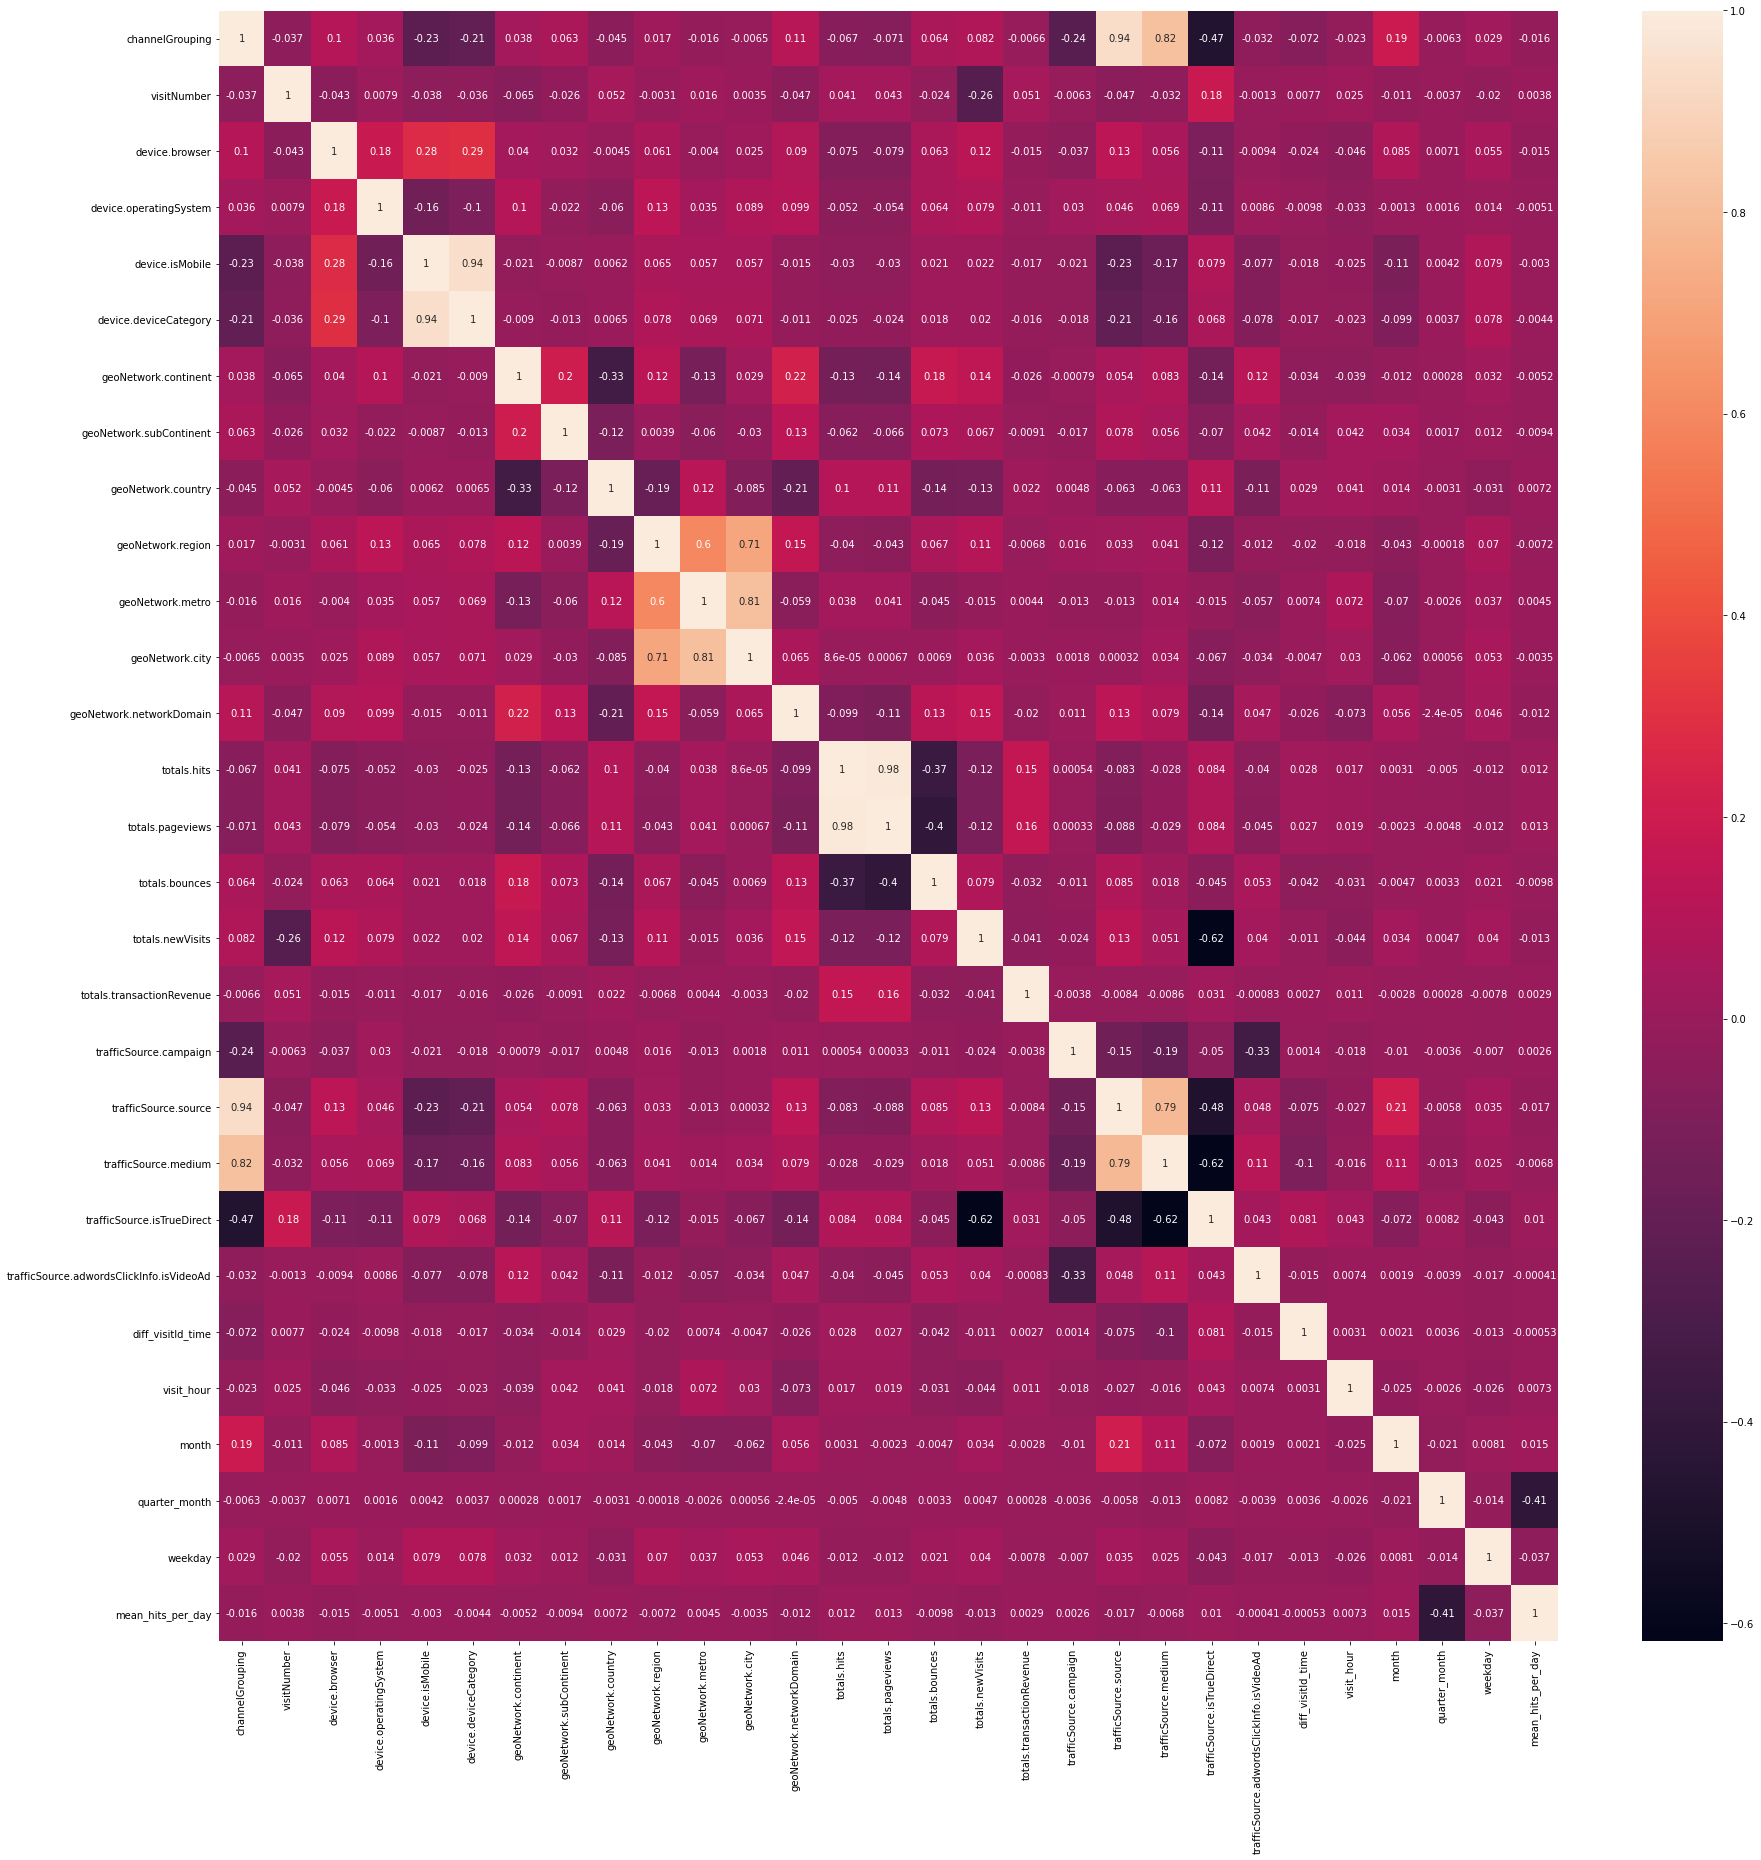

In [67]:
sns.heatmap(df_3.corr(), annot = True)

In [68]:
# Feature Engineering completed

In [69]:
# Dividing into training and testing

In [70]:
X = df_3.copy()

In [71]:
X.shape

(903653, 30)

In [72]:
X.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,formated_date,month,quarter_month,weekday,mean_hits_per_day
0,4,1.0,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,15,2016-09-02,9,0,4,4.638119
1,4,1.0,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
2,4,1.0,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,1,2016-09-02,9,0,4,4.638119
3,4,1.0,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0.0,0,149,5,0,1,0,5,2016-09-02,9,0,4,4.638119
4,4,2.0,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0.0,0,149,5,1,1,0,13,2016-09-02,9,0,4,4.638119


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   channelGrouping                           903653 non-null  int64         
 1   visitNumber                               903653 non-null  float64       
 2   device.browser                            903653 non-null  int64         
 3   device.operatingSystem                    903653 non-null  int64         
 4   device.isMobile                           903653 non-null  int64         
 5   device.deviceCategory                     903653 non-null  int64         
 6   geoNetwork.continent                      903653 non-null  int64         
 7   geoNetwork.subContinent                   903653 non-null  int64         
 8   geoNetwork.country                        903653 non-null  int64         
 9   geoNetwork.regi

In [74]:
# X_new = X.drop('date', axis = 1)

In [75]:
from datetime import datetime, date

In [76]:
X = X.set_index(X['formated_date'])
X = X.sort_index()

In [77]:
min(X['formated_date'])

Timestamp('2016-08-01 00:00:00')

In [78]:
max(X['formated_date'])

Timestamp('2017-08-01 00:00:00')

In [79]:
train = X['2016-08-01':'2017-05-31']
test  = X['2017-05-31':]


In [80]:
print(train.shape)
print(test.shape)

(765707, 30)
(140238, 30)


In [81]:
# Dropping date and target column
X_train = train.drop(['formated_date','totals.transactionRevenue'], axis = 1)
X_test = test.drop(['formated_date','totals.transactionRevenue'], axis=1)

In [82]:
print(X_train.shape)
print(X_test.shape)

(765707, 28)
(140238, 28)


In [83]:
X_train.head()

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,diff_visitId_time,visit_hour,month,quarter_month,weekday,mean_hits_per_day
formated_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01,2,1.0,11,7,0,0,3,6,102,375,93,648,10955,1.0,1.0,1.0,1.0,0,0,0,1,1,0,9,8,0,0,4.612934
2016-08-01,2,3.0,11,16,0,0,3,16,217,129,0,235,25841,1.0,1.0,1.0,0.0,0,0,0,1,1,0,9,8,0,0,4.612934
2016-08-01,6,1.0,11,7,0,0,2,12,212,57,78,366,0,1.0,1.0,1.0,1.0,0,267,6,0,1,0,23,8,0,0,4.612934
2016-08-01,2,1.0,11,16,0,0,2,15,28,375,93,648,3305,1.0,1.0,1.0,1.0,0,0,0,1,1,0,19,8,0,0,4.612934
2016-08-01,2,1.0,40,7,0,0,3,16,199,375,93,648,25841,1.0,1.0,1.0,1.0,0,0,0,1,1,0,4,8,0,0,4.612934


In [84]:
out = test['totals.transactionRevenue'].values

In [85]:
output = pd.DataFrame(out)

In [86]:
output.columns = ['ActualRevenue']

In [87]:
output.head()

,ActualRevenue
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [88]:
#  transaction revenue
y_train = np.log1p(train["totals.transactionRevenue"].values)
y_test = np.log1p(test["totals.transactionRevenue"].values)

In [89]:
print(y_train.shape)
print(y_test.shape)

(765707,)
(140238,)


In [90]:
# Defining the model
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 30,
    "min_child_samples": 100,
    "learning_rate": 0.1,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 2018,
    "verbosity": -1
}

In [91]:
lgb_train = lgb.Dataset(X_train, y_train)

In [92]:
lgb_eval = lgb.Dataset(X_test, y_test)

In [93]:
gbm = lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=[lgb_eval], early_stopping_rounds=500,verbose_eval=100)

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 1.72537
[200]	valid_0's rmse: 1.72097
[300]	valid_0's rmse: 1.72097
[400]	valid_0's rmse: 1.7215
[500]	valid_0's rmse: 1.72249
[600]	valid_0's rmse: 1.72319
[700]	valid_0's rmse: 1.72531
Early stopping, best iteration is:
[210]	valid_0's rmse: 1.72007


In [94]:
eval_predicted_revenue = gbm.predict(X_test, num_iteration=gbm.best_iteration)
eval_predicted_revenue[eval_predicted_revenue < 0] = 0 
output["predicted"] = np.expm1(eval_predicted_revenue)
output[["ActualRevenue","predicted"]].head(5)

,ActualRevenue,predicted
0,0.0,0.002731
1,0.0,0.007073
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000


In [95]:
pd.options.display.float_format = '{:.2f}'.format

In [96]:
output[(output['ActualRevenue'] > 0)].head()

,ActualRevenue,predicted
57,131310000.00,8105.70
59,5601400000.00,887231.35
63,71970000.00,8316.46
64,31930000.00,14228.14
66,417260000.00,978709.38


In [97]:
output

,ActualRevenue,predicted
0,0.00,0.00
1,0.00,0.01
2,0.00,0.00
3,0.00,0.00
4,0.00,0.00
...,...,...
140233,0.00,0.00
140234,0.00,0.00
140235,0.00,0.00
140236,0.00,0.00


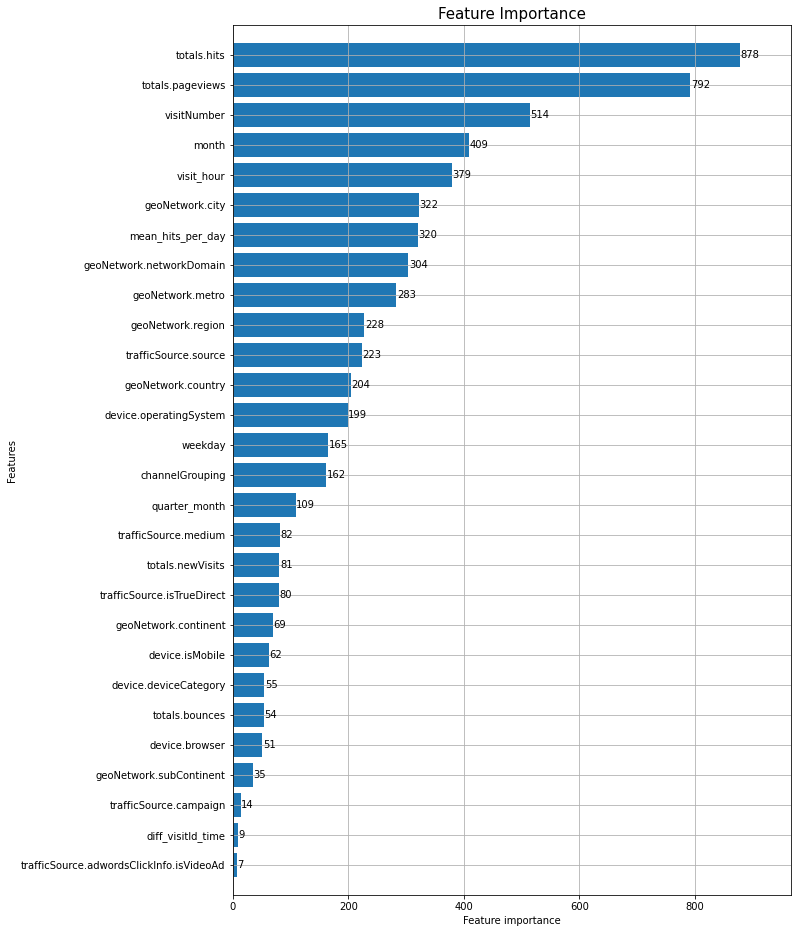

In [98]:
# Top 30 features 
fig, ax = plt.subplots(figsize=(10,16))
lgb.plot_importance(gbm, max_num_features=30, height=0.8, ax=ax)
plt.title("Feature Importance", fontsize=15)
plt.show()

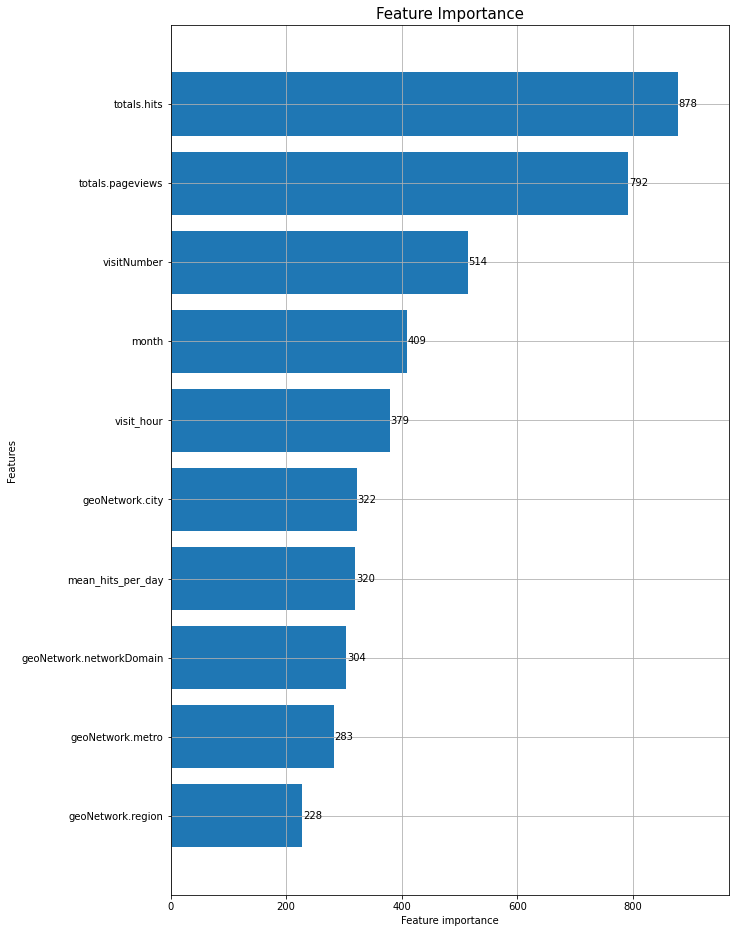

In [99]:
# Top 10 features
fig, ax = plt.subplots(figsize=(10,16))
lgb.plot_importance(gbm, max_num_features=10, height=0.8, ax=ax)
plt.title("Feature Importance", fontsize=15)
plt.show()

In [100]:
# Changing parameters of model

params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }

In [101]:
model_1 = lgb.train(params, lgb_train, 
                      num_boost_round=5000,
                      valid_sets=[lgb_train, lgb_eval],
                      early_stopping_rounds=100,
                      verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.81198	valid_1's rmse: 1.96169
[200]	training's rmse: 1.72103	valid_1's rmse: 1.86267
[300]	training's rmse: 1.67343	valid_1's rmse: 1.80912
[400]	training's rmse: 1.64676	valid_1's rmse: 1.77924
[500]	training's rmse: 1.62663	valid_1's rmse: 1.75979
[600]	training's rmse: 1.6137	valid_1's rmse: 1.74819
[700]	training's rmse: 1.60276	valid_1's rmse: 1.73922
[800]	training's rmse: 1.59434	valid_1's rmse: 1.73375
[900]	training's rmse: 1.58717	valid_1's rmse: 1.72989
[1000]	training's rmse: 1.58119	valid_1's rmse: 1.72716
[1100]	training's rmse: 1.57585	valid_1's rmse: 1.72542
[1200]	training's rmse: 1.57088	valid_1's rmse: 1.7241
[1300]	training's rmse: 1.56605	valid_1's rmse: 1.72295
[1400]	training's rmse: 1.5615	valid_1's rmse: 1.72198
[1500]	training's rmse: 1.55749	valid_1's rmse: 1.72148
[1600]	training's rmse: 1.55377	valid_1's rmse: 1.72114
[1700]	training's rmse: 1.55024	valid_1's rmse: 1.720

In [102]:
print("LightGBM features importance...")
gain = model_1.feature_importance('gain')
featureimp = pd.DataFrame({'feature': model_1.feature_name(), 
                   'split': model_1.feature_importance('split'), 
                   'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:10])

LightGBM features importance...
                 feature  split  gain
14      totals.pageviews  17122 37.36
13           totals.hits  17571 17.26
8     geoNetwork.country   3466  7.38
1            visitNumber   9697  5.86
24                 month   9532  4.00
18  trafficSource.source   4901  3.57
6   geoNetwork.continent   1372  2.88
23            visit_hour   9781  2.37
10      geoNetwork.metro   4915  2.00
27     mean_hits_per_day   9151  1.66


In [103]:
from xgboost import XGBRegressor
model_xg =  XGBRegressor()

In [104]:
params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

In [1]:
train_dmatrix = model_xg.DMatrix(data=X_train,label=y_train)

In [118]:
model_xg = XGBRegressor()

In [119]:
model_xg.fit(X_train, y_train)

[07:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [120]:
y_pred = model_xg.predict(X_test)



In [121]:
mse=mean_squared_error(y_test, y_pred, squared=False)

In [122]:
(mse)

1.7444133785264009

In [127]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [128]:
xg_reg.fit(X_train,y_train)

[07:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [129]:
preds = xg_reg.predict(X_test)

In [130]:
rmse = np.sqrt(mean_squared_error(y_test, preds))

In [131]:
rmse

1.9130794472795793

In [133]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [156]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [157]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.99,0.01,1.99,0.02
1,1.97,0.03,1.97,0.01
2,1.92,0.02,1.92,0.01
3,1.89,0.03,1.89,0.02
4,1.88,0.03,1.88,0.02
5,1.87,0.04,1.87,0.03
6,1.84,0.04,1.84,0.02
7,1.83,0.03,1.83,0.03
8,1.81,0.03,1.81,0.02
9,1.79,0.02,1.79,0.02


In [158]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)

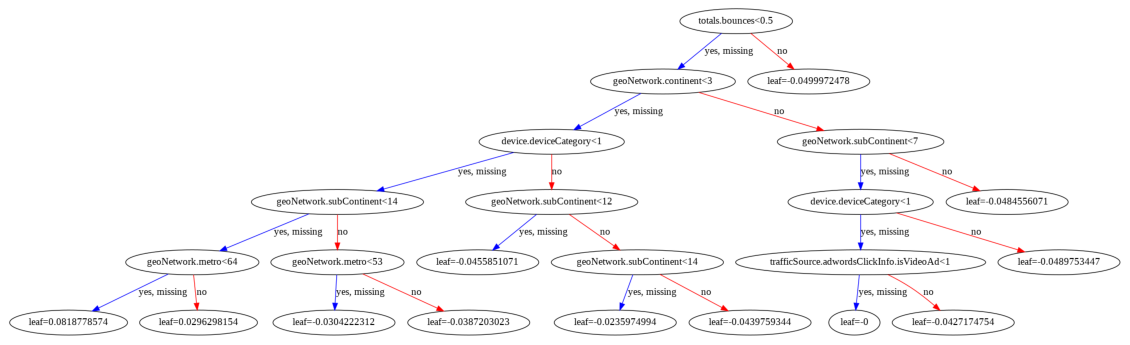

In [159]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()


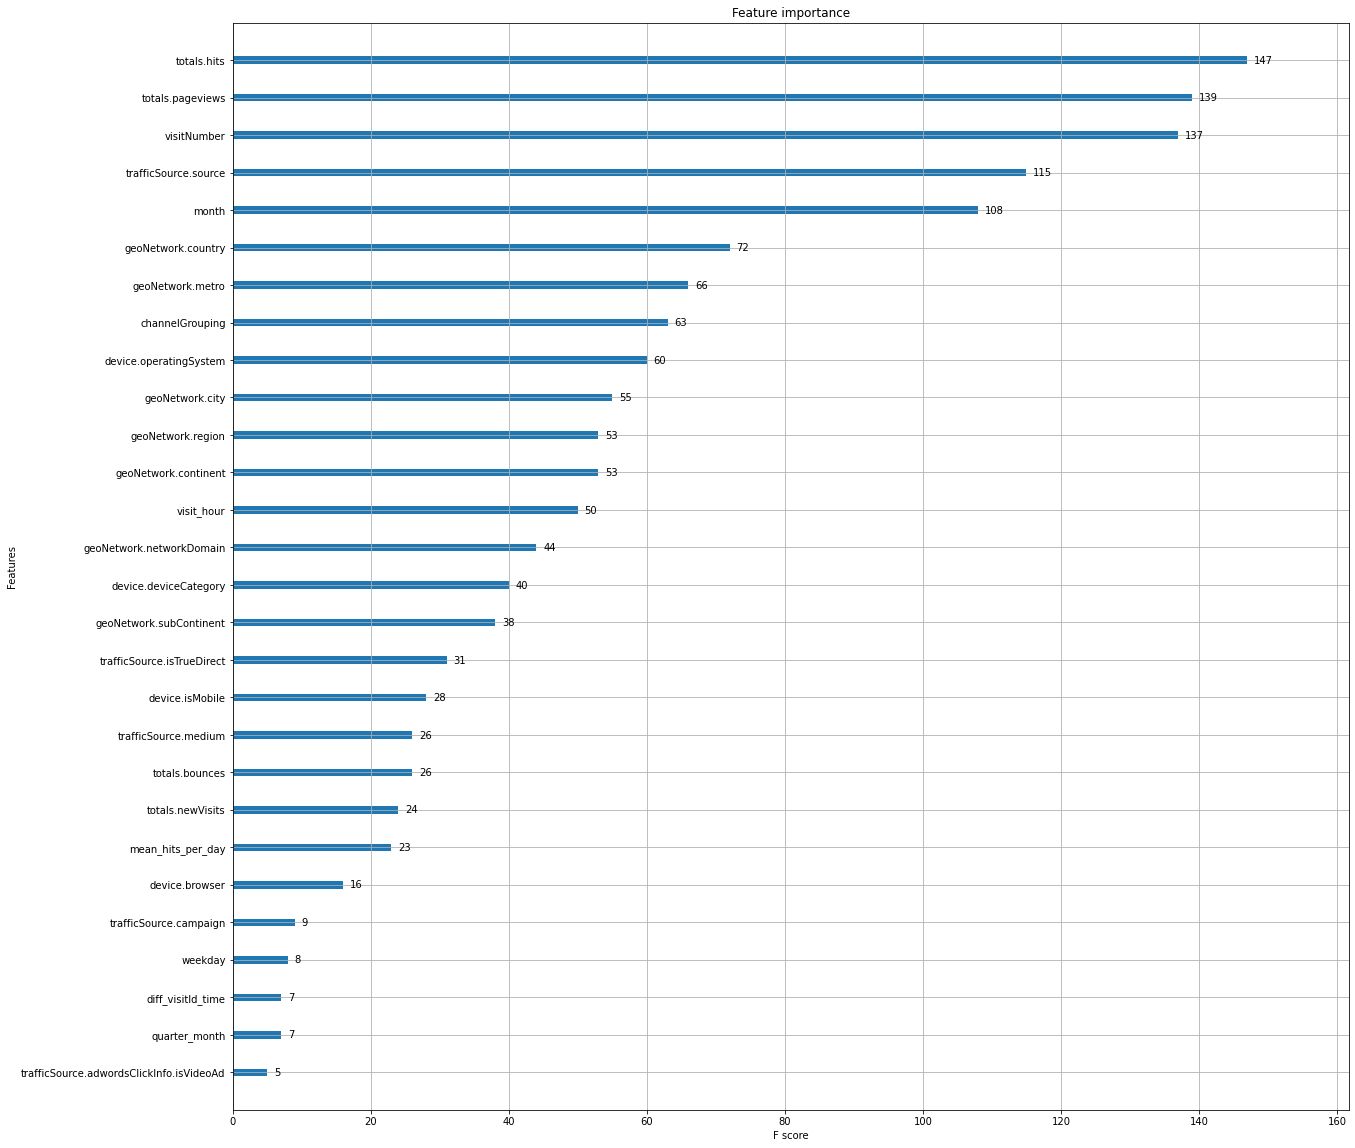

In [161]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [162]:
xgb_val_data = xgb.DMatrix(X_test, y_test)

In [163]:
y_pred = xg_reg.predict(xgb_val_data)

In [164]:
print(mean_squared_error(y_test, y_pred, squared=False))

1.772109558718598


In [167]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [169]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.97,0.01,1.97,0.02
1,1.91,0.06,1.91,0.04
2,1.81,0.03,1.81,0.01
3,1.77,0.03,1.77,0.03
4,1.76,0.04,1.76,0.04
5,1.75,0.05,1.76,0.04
6,1.72,0.03,1.72,0.02
7,1.71,0.03,1.72,0.03
8,1.69,0.02,1.70,0.02
9,1.68,0.01,1.69,0.01


In [168]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)
y_pred = xg_reg.predict(xgb_val_data)
print(mean_squared_error(y_test, y_pred, squared=False))

1.7454909970493806
